In [1]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve,auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from joblib import Parallel, delayed



In [ ]:
# Load data
notebook_path = Path.cwd()
file_path = notebook_path.parent / 'dataset' / 'bank.csv'
print(f"Loading data from: {file_path}")
data = pd.read_csv(file_path, header=0, sep=';')

In [3]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [4]:
#Assign features and labels
X=data.drop(columns=['response'])
y=data['response']


## Apply preprocessing steps to the dataset

In [5]:
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan', 'credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

# Label encode the response variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [6]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!


In [7]:
smote = SMOTE()
X_train ,y_train = smote.fit_resample(X_train, y_train)

In [8]:
#Declare Models
logreg = LogisticRegression(class_weight='balanced')
dtree = DecisionTreeClassifier()
rforest = RandomForestClassifier(n_estimators=100,class_weight='balanced')
gbm = GradientBoostingClassifier()
gnb = GaussianNB()
knn = KNeighborsClassifier()

In [9]:
# Define models
models = [
    ('Logistic Regression', logreg),
    ('Decision Tree', dtree),
    ('Random Forest', rforest),
    ('Gradient Boosting', gbm),
    ('Gaussian Naive Bayes', gnb),
    ('K Neighbors', knn)
]


In [10]:
# Iterate through models and train
for model_name, model in models:
        # Fit model
        model.fit(X_train, y_train)
        
        # Get predicted probabilities
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

In [11]:
def models_roc(X_train, y_train, X_test, y_test, models):
    """
    Plot ROC curves for multiple models in a single figure.
    
    Parameters:
    -----------
    X_train 
    y_train
    X_test 
    y_test
    models
    
    Returns:
    --------
    None (displays the plot)
    """
    plt.figure(figsize=(10, 8))
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    # Iterate through models and train
    for model_name, model in models:
        # Fit model
        model.fit(X_train, y_train)
        
        # Get predicted probabilities
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save plot
    plt.savefig('roc_comparison.png')
    plt.close()

    #Print results
    print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
    print("Classification Report: \n",classification_report(y_test,y_pred))



In [12]:
def train_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Helper function to train a single model and compute ROC metrics.
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Compute metrics
    metrics = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    return model_name, fpr, tpr, roc_auc, metrics


    

In [13]:
def models_roc(X_train, y_train, X_test, y_test, models, n_jobs=-1):
    """
    Plot ROC curves for multiple models in a single figure using parallel processing.
    
    Parameters:
    -----------
    X_train : array-like, training features
    y_train : array-like, training response
    X_test : array-like, test features
    y_test : array-like, test response
    models : list of tuples, each containing (model_name, model_instance)
    n_jobs : int, number of parallel jobs (-1 uses all available cores)
    
    Returns:
    --------
    None (displays the plot and prints metrics)
    """
    # Parallelize model training
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_model)(model_name, model, X_train, y_train, X_test, y_test)
        for model_name, model in models
    )
    
    # Initialize plot
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')


    # Plot ROC curves and print metrics
    for model_name, fpr, tpr, roc_auc, metrics in results:
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        # Print metrics for each model
        print(f"\n{model_name}:")
        print("Confusion Matrix:\n", metrics['confusion_matrix'])
        print("Classification Report:\n", classification_report(y_test, metrics['confusion_matrix'].argmax(axis=1)))
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save and close plot
    plt.savefig('roc_comparison.png')
    plt.close()

In [14]:
train_model(model_name, model, X_train, y_train, X_test, y_test)

('K Neighbors',
 array([0.        , 0.05823419, 0.11033187, 0.15604258, 0.2003757 ,
        0.2561052 , 1.        ]),
 array([0.        , 0.34593573, 0.56710775, 0.70699433, 0.77504726,
        0.84120983, 1.        ]),
 np.float64(0.8256979947041534),
 {'confusion_matrix': array([[6739, 1246],
         [ 310,  748]]),
  'classification_report': {'0': {'precision': 0.9560221307986948,
    'recall': 0.8439574201628053,
    'f1-score': 0.8965012638020486,
    'support': 7985.0},
   '1': {'precision': 0.37512537612838515,
    'recall': 0.7069943289224953,
    'f1-score': 0.49017038007863695,
    'support': 1058.0},
   'accuracy': 0.8279332080061926,
   'macro avg': {'precision': 0.66557375346354,
    'recall': 0.7754758745426502,
    'f1-score': 0.6933358219403428,
    'support': 9043.0},
   'weighted avg': {'precision': 0.8880592018546289,
    'recall': 0.8279332080061926,
    'f1-score': 0.848961943335459,
    'support': 9043.0}}})


Logistic Regression:
Confusion Matrix:
 [[6607 1378]
 [ 223  835]]


ValueError: Found input variables with inconsistent numbers of samples: [9043, 2]

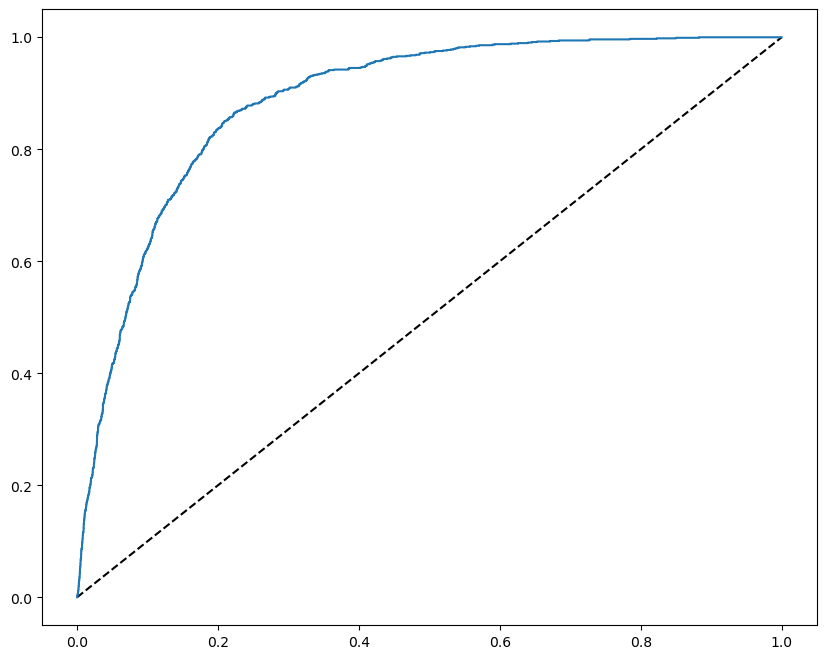

In [15]:
models_roc(X_train, y_train, X_test, y_test, models)

In [ ]:
# Create a DataFrame to store the results
res = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)), 
                 accuracy_score(y_test, svc.predict(X_test)), 
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])]
})

# Sort the results by accuracy
res = res.sort_values(by='ROC_AUC_Score', ascending=False)
# Display the results
print(res)  